In [ ]:
import zipfile
import os

# Step 3: Specify the zip file path and extraction folder path
# Replace 'your-zip-file.zip' with the actual path of your uploaded zip file.
# You can upload the zip file to the Colab environment or to Google Drive.

zip_file_path = '/content/drive/MyDrive/kidney.zip'  # Path to the uploaded zip file
extraction_folder = '/content/drive/MyDrive/KidneyDataset'  # Destination folder in Google Drive

# Step 4: Ensure the extraction folder exists
os.makedirs(extraction_folder, exist_ok=True)

# Step 5: Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print(f"Files extracted to: {extraction_folder}")

Files extracted to: /content/drive/MyDrive/KidneyDataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imutils import paths

In [ ]:


# Specify the directory where the files are stored
cyst_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Cyst'))
normal_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Normal'))
stone_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Stone'))
tumor_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Tumor'))

# Initialize lists to store image data and labels
data = []
labels = []

# Function to preprocess images and append to data and labels
def preprocess_and_append(imagePaths, label, data, labels, img_size=(64, 64)):
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size)
        image = image / 255.0  # Normalize to [0, 1]
        data.append(image)
        labels.append(label)

# Preprocess and append images for each class
preprocess_and_append(cyst_ImagePaths, 'cyst', data, labels)
preprocess_and_append(normal_ImagePaths, 'normal', data, labels)
preprocess_and_append(stone_ImagePaths, 'stone', data, labels)
preprocess_and_append(tumor_ImagePaths, 'tumor', data, labels)


# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)



In [ ]:
# Map string labels to numeric values
label_mapping = {
    'cyst': 0,
    'normal': 1,
    'stone': 2,
    'tumor': 3,

}
numeric_labels = np.array([label_mapping[label] for label in labels])

# Convert numeric labels to one-hot encoded labels
one_hot_labels = to_categorical(numeric_labels, num_classes=len(label_mapping))

# Verify the shape of the data and one-hot encoded labels
print("Shape of data:", data.shape)
print("Shape of one-hot encoded labels:", one_hot_labels.shape)


Shape of data: (12446, 64, 64, 3)
Shape of one-hot encoded labels: (12446, 4)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout


# Load the VGG16 model, without the top layer (which is the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add new top layers (classification head)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a different learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Verify the model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,389,316 (70.15 MB)

 Trainable params: 3,674,628 (14.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.6604 - loss: 0.8788 - val_accuracy: 0.9111 - val_loss: 0.2295
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9118 - loss: 0.2452 - val_accuracy: 0.9573 - val_loss: 0.1109
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.9602 - loss: 0.1063 - val_accuracy: 0.9649 - val_loss: 0.0960
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.9646 - loss: 0.0938 - val_accuracy: 0.9528 - val_loss: 0.1366
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.9716 - loss: 0.0787 - val_accuracy: 0.9849 - val_loss: 0.0549


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9842 - loss: 0.0554
Test accuracy: 0.9863454103469849


In [ ]:
y_pred = model.predict(X_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class index with the highest probability
y_test_classes = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded


In [ ]:
# Use the converted class labels
confusion_mat = confusion_matrix(y_test_classes, y_pred_classes)
print('Confusion Matrix: \n', confusion_mat)

Confusion Matrix: 
 [[ 739    0   11   15]
 [   0 1009    2    4]
 [   1    0  274    1]
 [   0    0    0  434]]


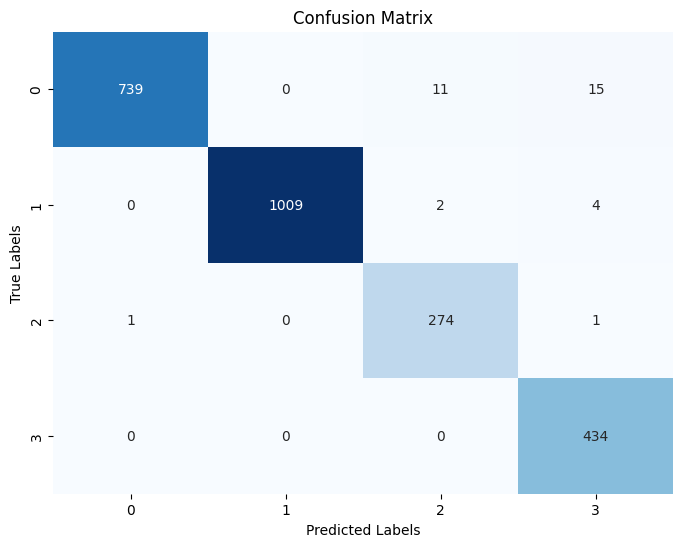

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       765
           1       1.00      0.99      1.00      1015
           2       0.95      0.99      0.97       276
           3       0.96      1.00      0.98       434

    accuracy                           0.99      2490
   macro avg       0.98      0.99      0.98      2490
weighted avg       0.99      0.99      0.99      2490



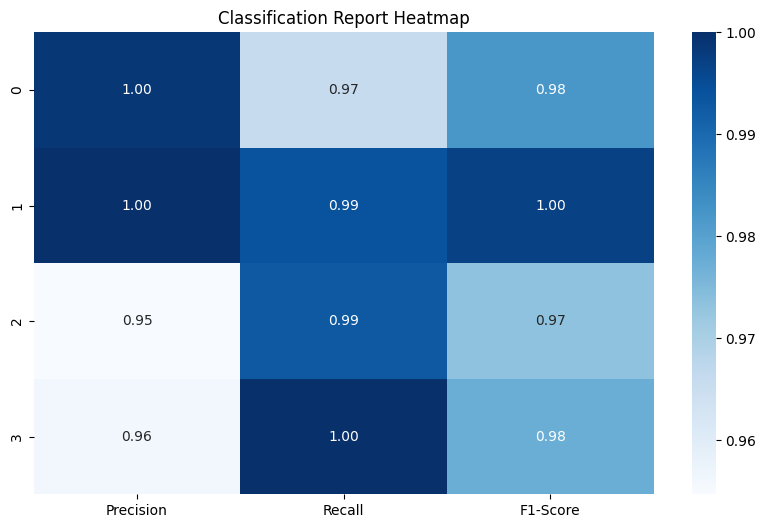

In [ ]:
# Plotting a heatmap for precision, recall, and F1-score
class_report = classification_report(y_test_classes, y_pred_classes, output_dict=True)
class_names = [str(label) for label in class_report.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]

# Extract precision, recall, and F1-score for each class
heatmap_data = [[class_report[class_name]['precision'], class_report[class_name]['recall'], class_report[class_name]['f1-score']] for class_name in class_names]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=['Precision', 'Recall', 'F1-Score'], yticklabels=class_names, cmap='Blues')
plt.title('Classification Report Heatmap')
plt.show()